In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.optimizers import RMSprop, Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import keras.backend as K
import pickle
from tensorflow.keras.utils import to_categorical
from keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense,concatenate,add
)
from keras.optimizers import SGD
import glob
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
import seaborn as sns
from keras import Sequential
import math
import keras
from keras.preprocessing import image
import configparser

2022-11-12 09:51:43.326201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [3]:
BASE_DIR = '../data/UTKFace/'
config = configparser.ConfigParser()
config.read('config.ini')
img_size = (int(config['IMG']['width']), int(config['IMG']['height']))

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize(img_size, Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    return features

X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
x_train = X[:14000]
y_gender_train = y_gender[:14000]
x_va = X[13000:]
y_gender_va = y_gender[13000:]

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

## Data Analysis

## Build Gender Network

In [4]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

In [6]:
# n = 64,128,256,512
def residual_module(inputs, n):
   # 1x1 conv with n filters
    identity_layer = Conv2D(n, (1,1), activation='relu')(inputs)
    
    conv_1 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (inputs)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_2 = Conv2D(n, kernel_size=(3, 3), activation='relu',padding='same') (conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_3 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (conv_2)
    conv_3 = layers.BatchNormalization()(conv_3)
  
    out = add([conv_2, identity_layer])
    out = Activation('relu')(out)
    return out

input_shape = (img_size + (3,))
inputs = Input((input_shape))

#pre-conv layer
pre_conv = Conv2D(64,(7,7),activation='relu',padding='same')(inputs)
pre_layer = MaxPooling2D(pool_size=(3, 3))(pre_conv)


# Level 1 of residual, 32 conv filters
L1 = residual_module(pre_layer, 32)

# # Level 2 of residual, 64 conv filters
L2 = residual_module(L1, 64)

# # Level 3 of residual, 128 conv filters
L3 = residual_module(L2, 128)

# # Level 4 of residual, 256 conv filters
L4 = residual_module(L3, 256)


# Outer level of residual block
L0_identity = Conv2D(256, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(pre_layer)
bottleneck = add([L4, L0_identity])
bottleneck = Activation('relu')(bottleneck)
bottleneck = layers.BatchNormalization()(bottleneck)


# max pooling
bottleneck = layers.MaxPooling2D(pool_size=(4, 4))(bottleneck)
flatten = Flatten() (bottleneck)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)


dropout_1 = Dropout(0.3) (dense_1)
dropout_1 = Dropout(0.5) (dropout_1)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)


gender_model = Model(inputs=inputs, outputs=output_1)

gender_model.compile(optimizer="adam", 
              loss={
                  'gender_out': 'binary_crossentropy'},
              metrics={       
                  'gender_out': 'accuracy'})
gender_model.summary()

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-11-12 09:54:08.879114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 09:54:08.886099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-12 09:54:08.886824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 09:54:08.887245: I tensorflow/core/common_runtime/pluggable_device/plug

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 42, 42, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [7]:
# train model
history = gender_model.fit(x=x_train, y=y_gender_train, batch_size=64, epochs=10, validation_data=[x_va,y_gender_va])
gender_model.save("gender_model")

Epoch 1/10


2022-11-12 09:54:51.958691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 2.3087 - accuracy: 0.6094

2022-11-12 09:57:12.813364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 169s 747ms/step - loss: 2.3087 - accuracy: 0.6094 - val_loss: 2.8422 - val_accuracy: 0.5285
Epoch 2/10
219/219 [==============================] - 146s 655ms/step - loss: 0.5464 - accuracy: 0.7389 - val_loss: 0.6602 - val_accuracy: 0.7437
Epoch 3/10
219/219 [==============================] - 167s 765ms/step - loss: 0.4689 - accuracy: 0.7779 - val_loss: 0.4500 - val_accuracy: 0.8069
Epoch 4/10
219/219 [==============================] - 186s 848ms/step - loss: 0.4014 - accuracy: 0.8136 - val_loss: 0.3732 - val_accuracy: 0.8420
Epoch 5/10
219/219 [==============================] - 186s 850ms/step - loss: 0.3579 - accuracy: 0.8367 - val_loss: 0.3278 - val_accuracy: 0.8549
Epoch 6/10
219/219 [==============================] - 191s 872ms/step - loss: 0.3286 - accuracy: 0.8514 - val_loss: 0.3610 - val_accuracy: 0.8317
Epoch 7/10
219/219 [==============================] - 207s 945ms/step - loss: 0.3119 - accuracy: 0.8618 - val_loss: 0.3143 - val_accura

INFO:tensorflow:Assets written to: gender_model/assets


INFO:tensorflow:Assets written to: gender_model/assets


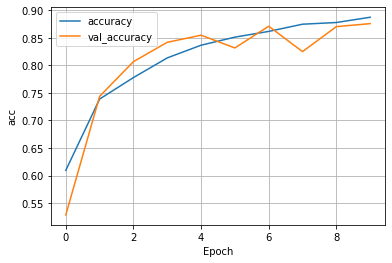

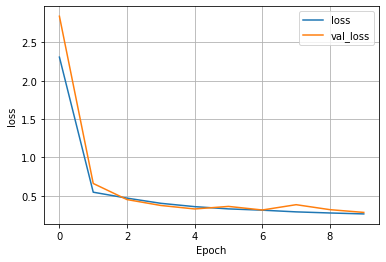

In [8]:
plot_acc_his(history)
plot_loss_his(history)

## Build Age network

In [ ]:
BASE_DIR = '../data/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}
df.sample(frac=1)

In [ ]:
display(Image.open(df['image'][19]))

In [ ]:
sns.set_theme()
sns.displot(df['age'],kde=True, bins=30)

In [ ]:
age24_28 = []

for i in range(len(df)):
    if df['age'].iloc[i] >=24 and df['age'].iloc[i] <=28:
        age24_28.append(df.iloc[i])
age24_28 = pd.DataFrame(age24_28)
age24_28 = age24_28.sample(frac=0.3)

df1 = df[df['age'] <24]
df2 = df[df['age'] >28]
df = pd.concat([df1,df2, age24_28], ignore_index = True)

In [ ]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [ ]:
df = df[df['age']<=60]

In [ ]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [ ]:
age_under4 = []
for i in range(len(df)):
    if df['age'].iloc[i] <=4:
        age_under4.append(df.iloc[i])
age_under4 = pd.DataFrame(age_under4)
age_under4 = age_under4.sample(frac=0.5)

df1 = df[df['age'] >4]
df = pd.concat([df1, age_under4], ignore_index = True)

In [ ]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [ ]:
# train, validate data split
X = extract_features(df['image'])
X = X/255.0
y_age = np.array(df['age'])

age_off = 5
num_group = 60//age_off
age_group = []

for i in range(len(y_age)):
    group_num = int(math.ceil(y_age[i]/age_off))
    age_group.append(group_num)
    
y_age = np.array(age_group)
y_age = to_categorical(y_age)


In [ ]:
sns.boxplot(data=df, x='gender', y='age')

In [ ]:
# split data based on gender, then do age group prediction


In [ ]:
x_train = X[:14000]
y_age_train = y_age[:14000]
x_va = X[11000:14500]
y_age_va = y_age[11000:14500]

inputs = Input(img_size + (3,))
conv1 = keras.layers.Conv2D(filters = 16 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (inputs)
conv1 = layers.BatchNormalization()(conv1)
maxpool1 = keras.layers.MaxPool2D((2,2)) (conv1)

conv2 = keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool1)
conv2 = layers.BatchNormalization()(conv2)
maxpool2 = keras.layers.MaxPool2D((2,2)) (conv2)


conv3 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool2)
conv3 = layers.BatchNormalization()(conv3)
maxpool3 = keras.layers.MaxPool2D((2,2)) (conv3)

# Flatten

flatten = keras.layers.Flatten()(maxpool3)

# Dense Layer

dense = keras.layers.Dense(128 , activation = 'relu') (flatten)

dense = layers.BatchNormalization()(dense)
drop = keras.layers.Dropout(0.4) (dense)

# Output 

output = keras.layers.Dense(num_group+1, activation = 'softmax' , name = 'gender_output') (drop)




age_model =  keras.models.Model(inputs=[inputs], outputs = [output])

age_model.compile(
    optimizer=  'adam',
    loss= 'categorical_crossentropy',
    metrics = 'accuracy'
)

In [ ]:
history = age_model.fit(x= x_train , y = y_age_train, batch_size=64, epochs=50, validation_data=(x_va, y_age_va))
age_model.save("age_model")

In [ ]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

In [ ]:
plot_acc_his(history)
plot_loss_his(history)

In [ ]:
def pred_gender_age_group(idx):
    
    im = X[idx].reshape(1,32,32,3)
    # age group predict
    age_pred = age_model.predict(im)
    i = np.argmax(age_pred.flatten())
    low = age_off * (i-1)
    high = age_off * i
    
    # gender predict
    gender_pred = gender_model.predict(im)
    pred_gender = "male" if gender_pred.flatten()[0] <= 0.5 else "femal"
    true_gender = "male" if df["gender"][idx] ==0 else "femal"
    
    
    # print info 
    print("True gender: ", true_gender)
    print("Predict gender: ", pred_gender)
    print("True Age: ", df['age'][idx])
    print("Predict age group: %d - %d "%(low,high))
    img = Image.open(df['image'].iloc[idx])
    display(img)

In [ ]:
pred_gender_age_group(15000)